In [82]:
!pip install -q openpyxl
!pip install -q umap

In [85]:
import nltk
import pandas as pd
import numpy as np
import umap
import re
import gensim
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from nltk.collocations import *
import seaborn as sns

In [3]:
df_text = pd.read_excel('ru_texts.xlsx')

In [4]:
df_text.sample(5)

name  \
312                       Каменный гость.txt   
47                      Выигрышный билет.txt   
38                  Восклицательный знак.txt   
263                            Мимоездом.txt   
152  Молитва (В минуту жизни трудную...).txt   

                                                  text  
312  Александр Пушкин\nКАМЕННЫЙ ГОСТЬ\nLeporello. O...  
47   Антон Чехов\nВЫИГРЫШНЫЙ БИЛЕТ\nИван Дмитрич, ч...  
38   Антон Чехов\nВОСКЛИЦАТЕЛЬНЫЙ ЗНАК\n(СВЯТОЧНЫЙ ...  
263  Александр Иванович Герцен\n  \n  \n   МИМОЕЗДО...  
152  МОЛИТВА\nВ минуту жизни трудную\nТеснится ль в...

In [5]:
def tidy(line):
    line = line.lower().strip()
    line = re.sub(r'<(.*?)>',' ',line)
    line = re.sub(r'[^\u0400-\u04FF\s.,!?]', '', line) 
    line = re.sub(r'[.]{1}','',line)
    line = re.sub(r'[\d]', '', line)
    line = re.sub(r'[a-zA-Z]', '', line)
    line = line.replace('"','').replace('“','').replace('”','').replace('’','').replace('‘','').replace('—','').replace('-','').replace(':', '').replace(';','').replace('\n', ' ').replace('(', '').replace(')', '').replace('»', '').replace('«', '').replace('*','')
    if len(line) != 0:
        return(line.strip())
    else:
        return ''

In [6]:
'w eer rr   '.strip()

'w eer rr'

In [7]:
summary_text = ''.join([tidy(line) for line in df_text['text']])

In [8]:
len(summary_text)

7171691

In [27]:
for line in df_text['text']:
    print(line)
    print(len(line))
    break

Получил ваше интересное письмо и очень рад случаю ответить на него.
   Вы говорите, первое, что правильно понятый эгоизм - это благо для всех, и что эта истина с разрушением старого строя быстро войдет в сознание людей. А как только истина войдет в сознание людей, так и наступит общее благо. Второе то, что ум человеческий может придумать условия общежития, при коих эгоизм одного человека не будет вредить другому. И третье то, что при этих придуманных условиях общежития, может, как вы выражаетесь, иметь место до известной степени и элемент принуждения, т.е. что для того, чтобы люди исполняли требования придуманного теоретиками наилучшего устройства, можно и должно употреблять насилие.
   Три положения эти признаются одинаково всеми учеными, политиками и экономистами нашего времени. Ученые теоретики только не так откровенно, как вы, высказывают их. На этих трех положениях, основаны рассуждения сотен, тысяч людей, считающих себя руководителями человечества. А между тем все три положения э

In [9]:
tokens = nltk.wordpunct_tokenize(summary_text)
finder = BigramCollocationFinder.from_words(tokens)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder.nbest(bigram_measures.pmi, 15)

[('аааа', 'штоб'),
 ('ааааа', 'доносившихся'),
 ('аачем', 'перегорел'),
 ('абдель', 'кадер'),
 ('абулгази', 'баядурхана'),
 ('австрийской', 'империей'),
 ('автоматическом', 'лифте'),
 ('агафию', 'федосеевну'),
 ('адмиралтейский', 'шпиль'),
 ('академический', 'словарь'),
 ('акима', 'нахимова'),
 ('акимом', 'данилычем'),
 ('аккуратном', 'плешивом'),
 ('аккуратные', 'скабиозы'),
 ('аксиомами', 'гуманистического')]

In [69]:
all_bigrams = finder.nbest(bigram_measures.pmi, 25000)
bigrams = [bigram for bigram in all_bigrams]

In [ ]:
all_bigrams = finder.score_ngrams(bigram_measures.pmi)
bigrams = [bigram for bigram, score in all_bigrams]

In [70]:
len(all_bigrams)

25000

In [71]:
sentences_with_bigrams = [[''.join([w1, '_', w2]) for w1, w2 in bigrams]]

In [72]:
model = Word2Vec(sentences_with_bigrams, vector_size=100, window=5, min_count=1, workers=4)

In [73]:
bigram_vectors_array = np.array([model.wv[bigram] for bigram in model.wv.index_to_key])

In [74]:
len(sentences_with_bigrams[0])

25000

# Old_TSNE_Check

In [75]:
tsne = TSNE(n_components=2, random_state=42)
bigram_vectors_2d = tsne.fit_transform(bigram_vectors_array)

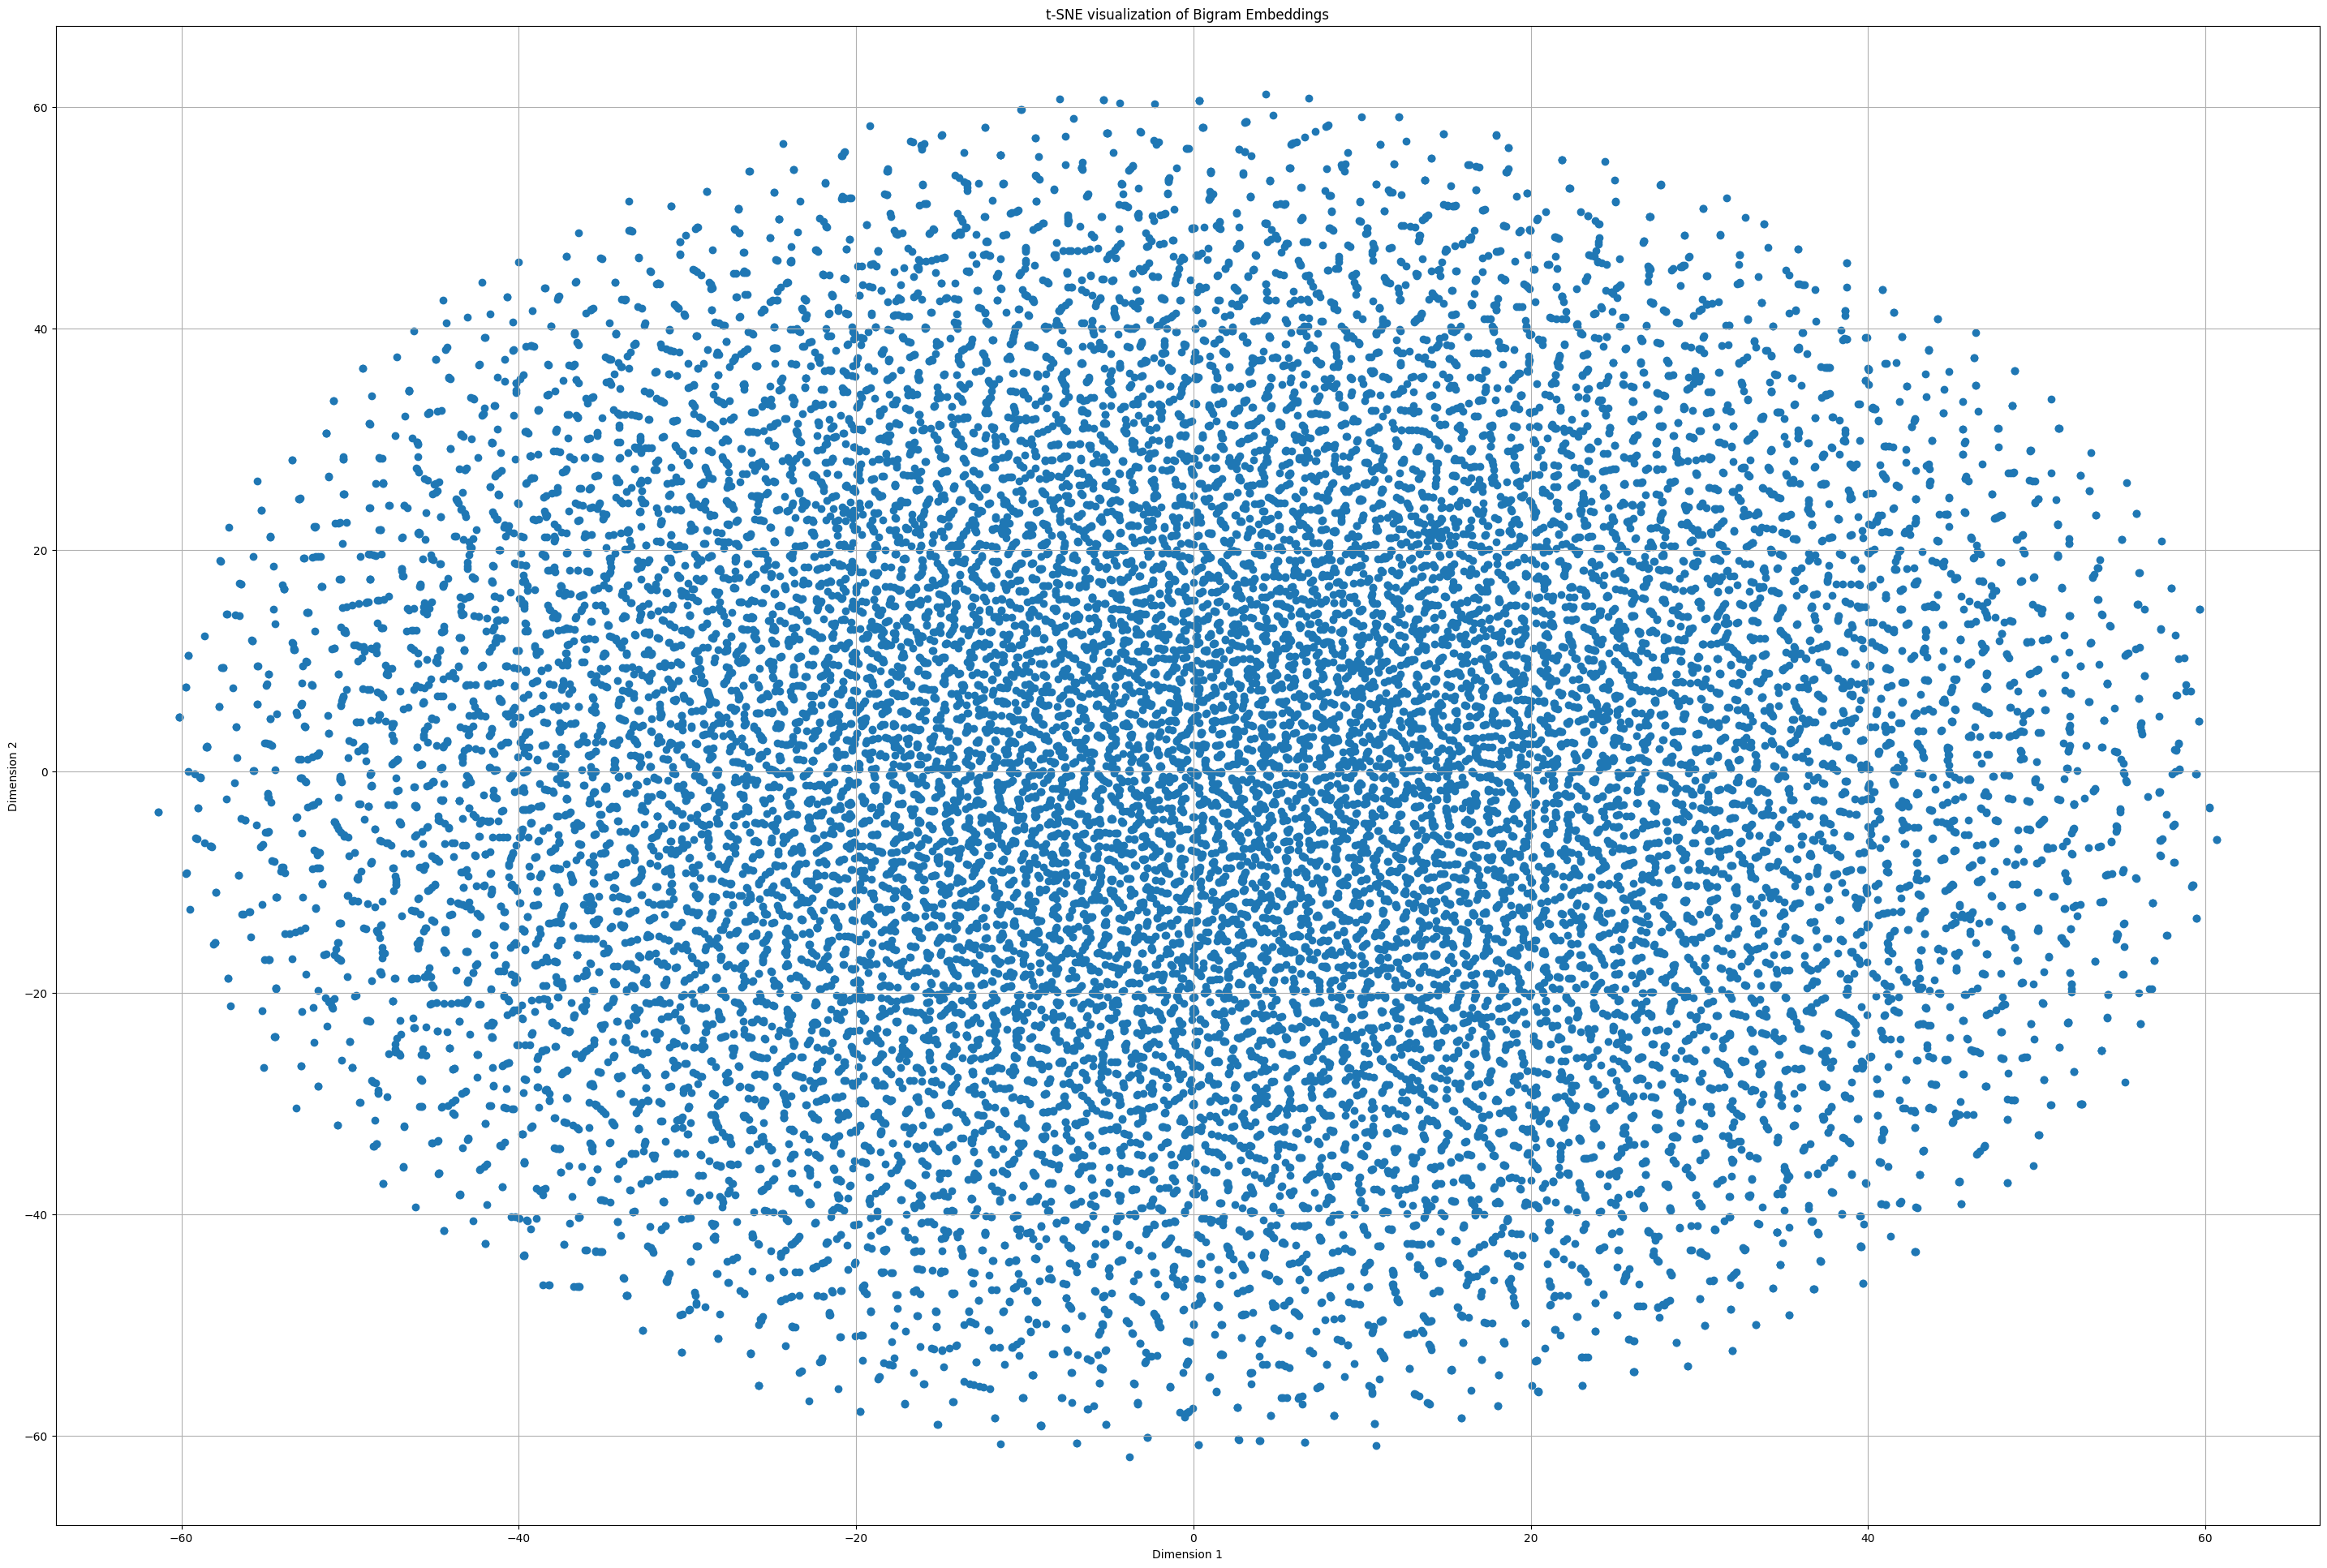

In [76]:
bigram_labels = model.wv.index_to_key

plt.figure(figsize=(36, 24))
plt.scatter(bigram_vectors_2d[:, 0], bigram_vectors_2d[:, 1])

plt.title('t-SNE visualization of Bigram Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


#Izomaps

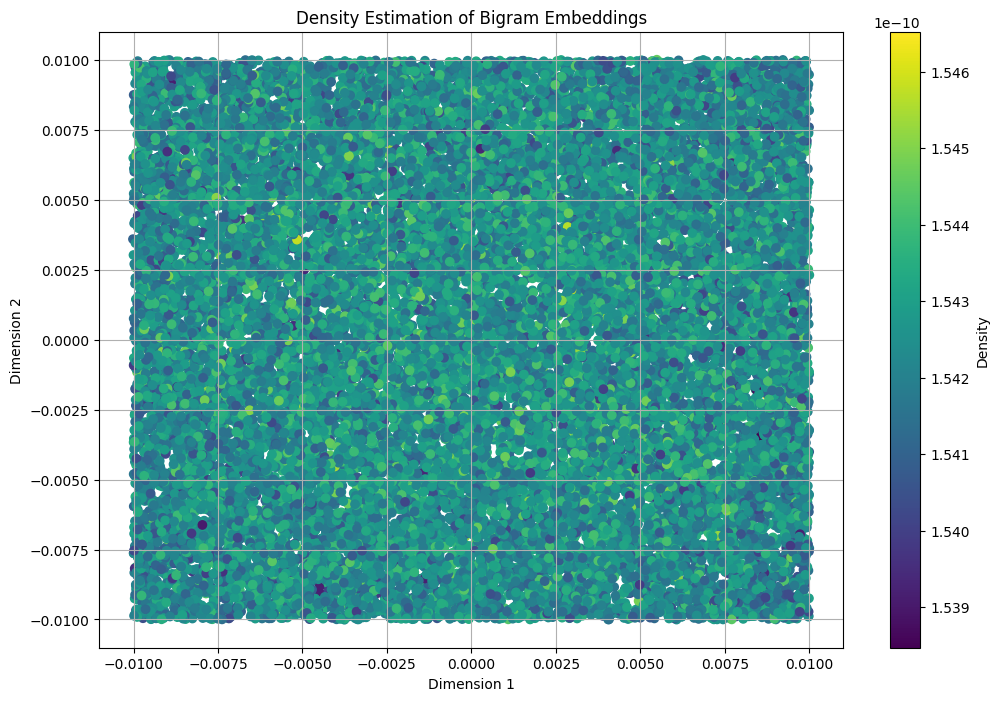

In [78]:
kde = KernelDensity(bandwidth=0.5)
kde.fit(bigram_vectors_2d)

log_density = kde.score_samples(bigram_vectors_2d)
density = np.exp(log_density)

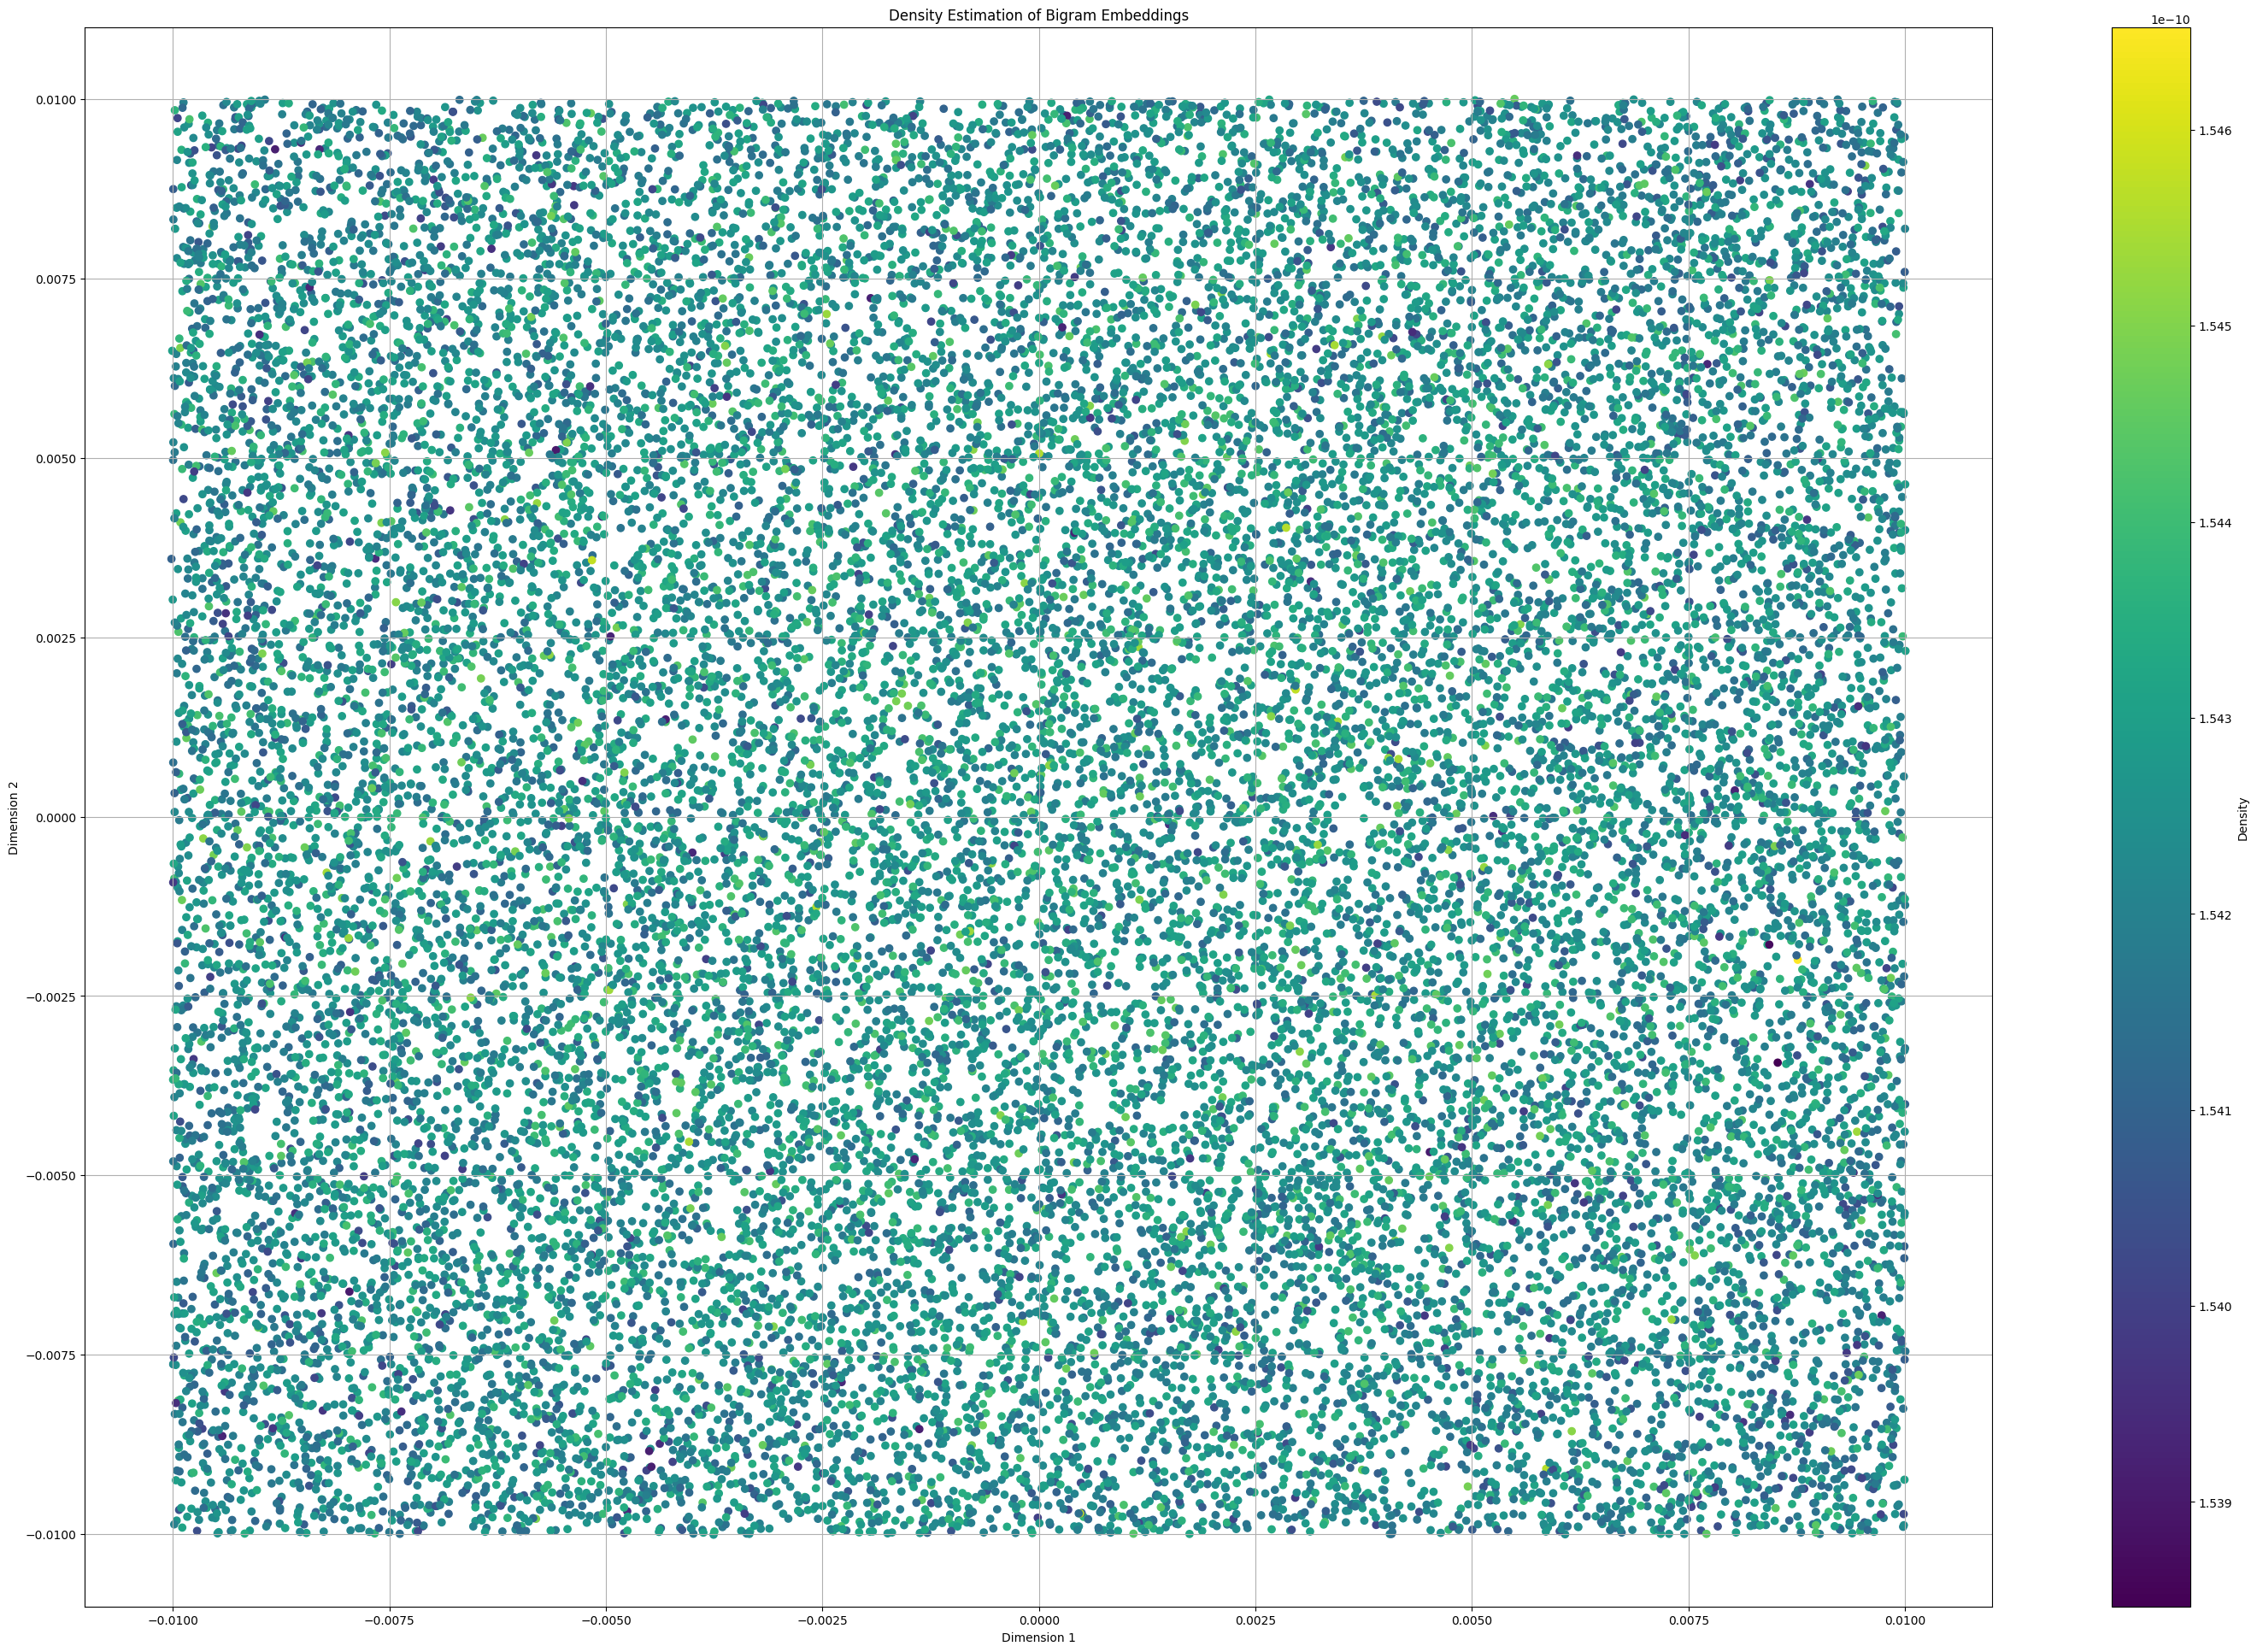

In [79]:
plt.figure(figsize=(36, 24))
plt.scatter(bigram_vectors_array[:, 0], bigram_vectors_array[:, 1], c=density, cmap='viridis')
plt.colorbar(label='Density')
plt.title('Density Estimation of Bigram Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

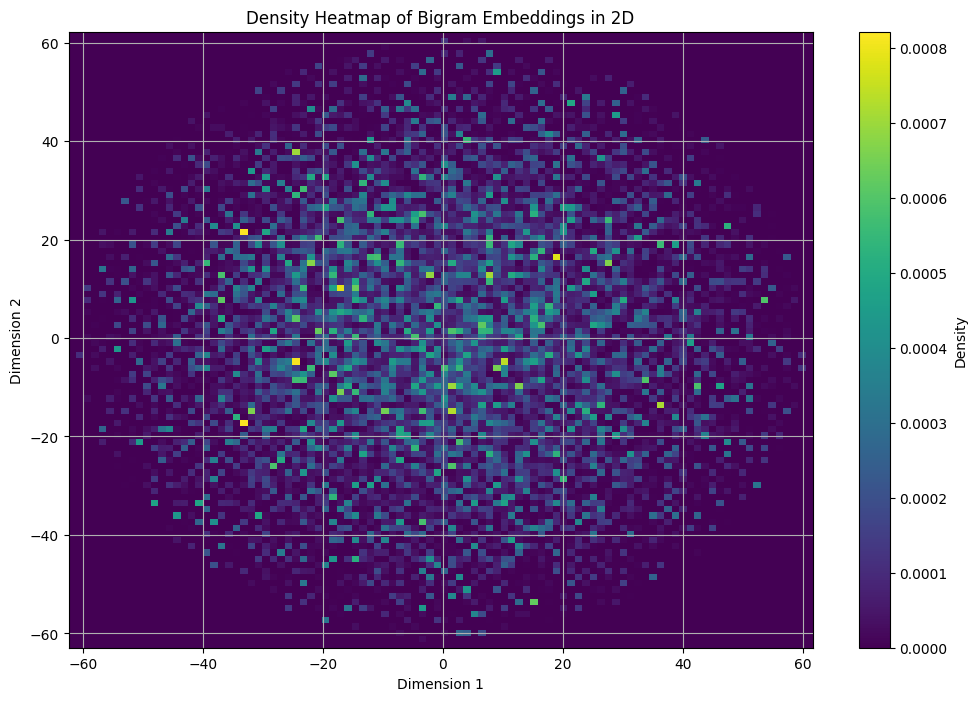

In [94]:
kde_2d = KernelDensity(bandwidth=0.2)
kde_2d.fit(bigram_vectors_2d)

x_min, x_max = bigram_vectors_2d[:, 0].min() - 1, bigram_vectors_2d[:, 0].max() + 1
y_min, y_max = bigram_vectors_2d[:, 1].min() - 1, bigram_vectors_2d[:, 1].max() + 1
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
log_density_2d_grid = kde_2d.score_samples(grid_points)
density_2d_grid = np.exp(log_density_2d_grid).reshape(x_grid.shape)

plt.figure(figsize=(12, 8))
plt.imshow(density_2d_grid, cmap='viridis', extent=(x_min, x_max, y_min, y_max), origin='lower', aspect='auto')
plt.colorbar(label='Density')
plt.title('Density Heatmap of Bigram Embeddings in 2D')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

In [142]:
f = open('extract_anekdots.txt').read()
f = f.replace('\n\n', '\n').replace('-', '')

In [143]:
len(f)

9062418

In [144]:
print(f[0:100])

 Как водичка ?
 А я здесь как женшина сижу, а не как термометр.

 Я затрудняюсь поставить вам диагно


In [150]:
tokens_a = nltk.wordpunct_tokenize(f)
finder_a = BigramCollocationFinder.from_words(tokens_a)
bigram_measures_a = nltk.collocations.BigramAssocMeasures()
finder_a.nbest(bigram_measures_a.pmi, 15)

[('!!!!....', 'Фуникулёр'),
 ('!!!!???', 'Смогто'),
 ('!!.', 'Воооова'),
 ('!!.."', 'Спаниель'),
 ('!?!!!', 'НАЛИВАААЙ'),
 ('"!....', 'Хельг'),
 ('"!?!?', 'Агась'),
 ('"....', 'Онон'),
 ('%,://%', 'КурлыКурлы'),
 ('******', 'МАТЕРИ'),
 ('....!!!!!!', 'Тетке'),
 ('12ти', 'закричим'),
 ('12этажная', 'ракетаноситель'),
 ('141592653', '="'),
 ('14дорас', 'грёбаный')]

In [154]:
all_bigrams_a = finder_a.nbest(bigram_measures_a.pmi, 5000)
bigrams_a = [bigram_a for bigram_a in all_bigrams_a]

sentences_with_bigrams_a = [[''.join([w1, '_', w2]) for w1, w2 in bigrams_a]]

model_a = Word2Vec(sentences_with_bigrams_a, vector_size=100, window=5, min_count=1, workers=4)

bigram_vectors_array_a = np.array([model_a.wv[bigram_a] for bigram_a in model_a.wv.index_to_key])

tsne_a = TSNE(n_components=2, random_state=42)
bigram_vectors_2d_a = tsne.fit_transform(bigram_vectors_array_a)

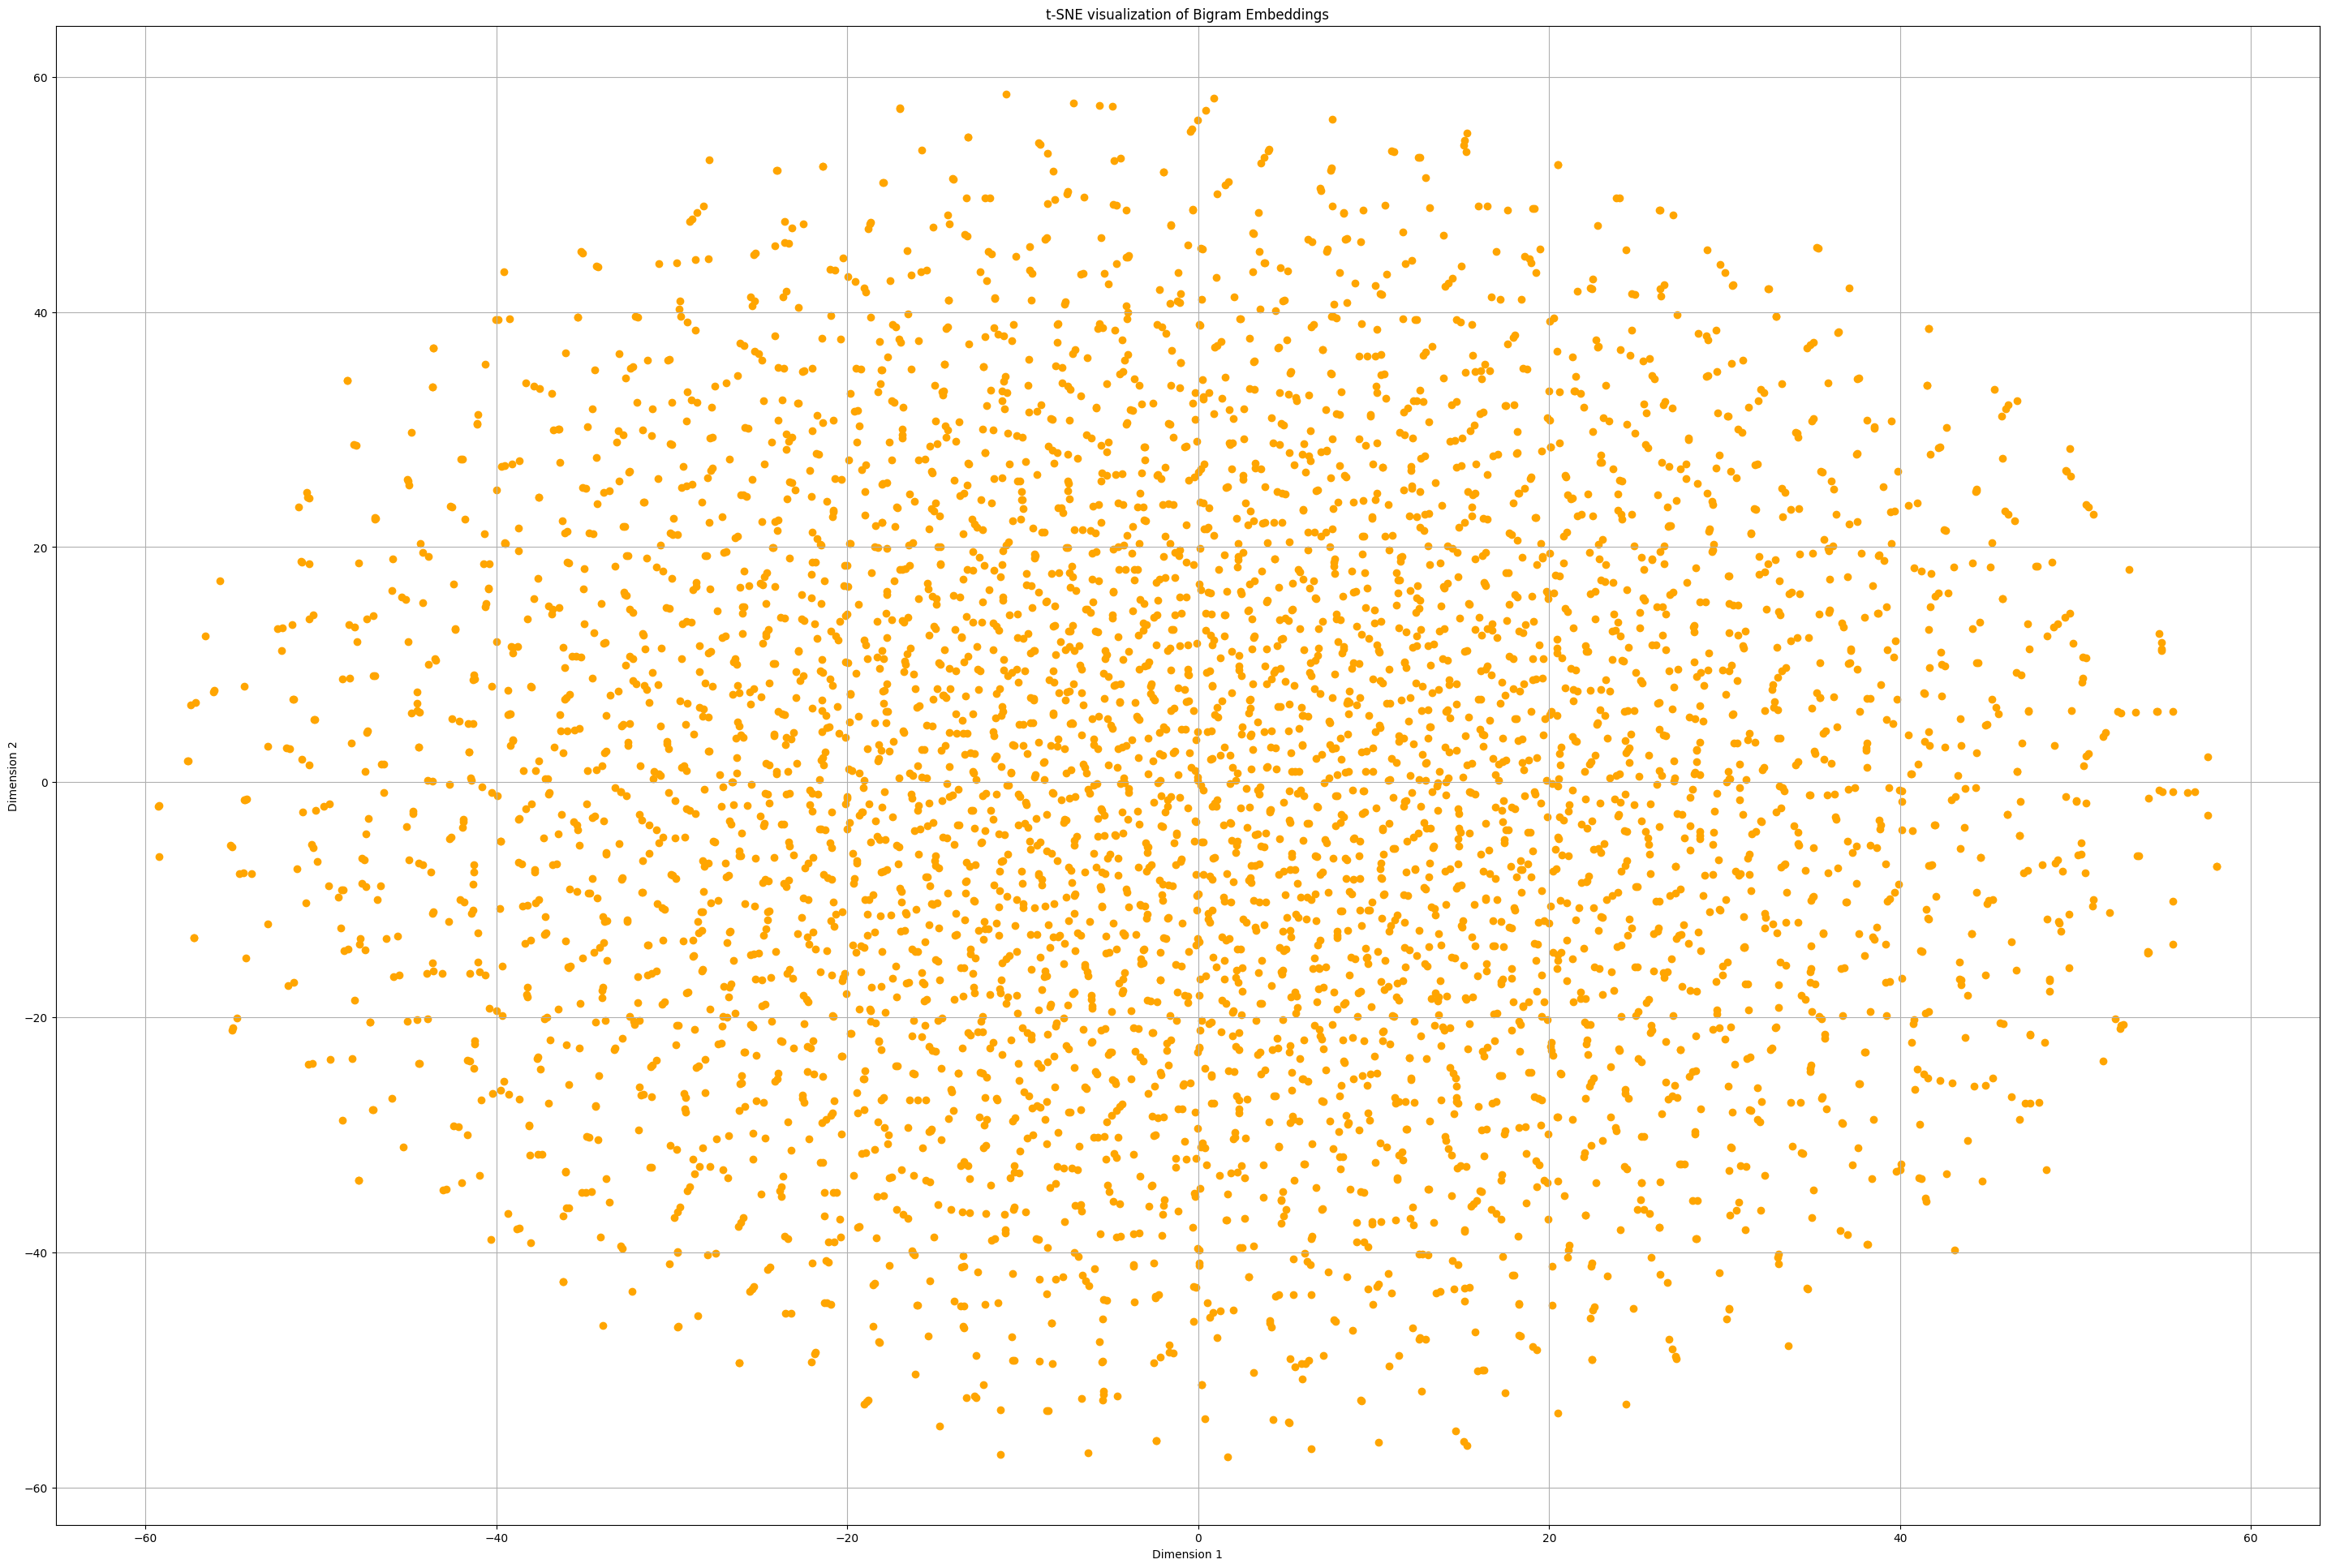

In [156]:
bigram_labels_a = model_a.wv.index_to_key

plt.figure(figsize=(36, 24))
plt.scatter(bigram_vectors_2d_a[:, 0], bigram_vectors_2d_a[:, 1], color = 'orange')

plt.title('t-SNE visualization of Bigram Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

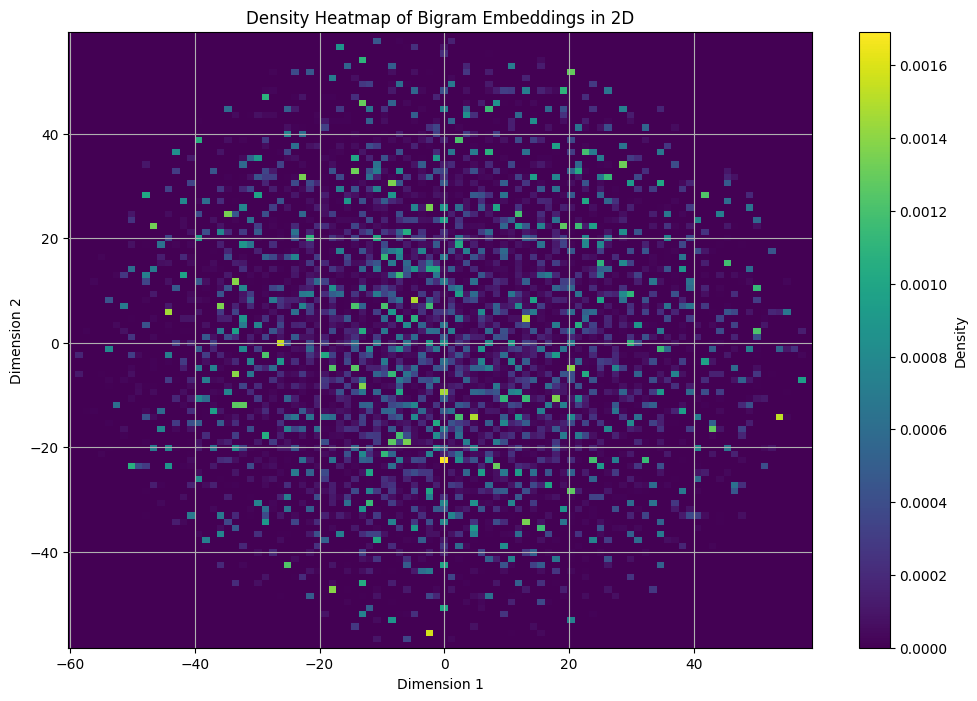

In [157]:
kde_2d_a = KernelDensity(bandwidth=0.2)
kde_2d_a.fit(bigram_vectors_2d_a)

x_min_a, x_max_a = bigram_vectors_2d_a[:, 0].min() - 1, bigram_vectors_2d_a[:, 0].max() + 1
y_min_a, y_max_a = bigram_vectors_2d_a[:, 1].min() - 1, bigram_vectors_2d_a[:, 1].max() + 1

x_grid_a, y_grid_a = np.meshgrid(np.linspace(x_min_a, x_max_a, 100), np.linspace(y_min_a, y_max_a, 100))
grid_points_a = np.vstack([x_grid_a.ravel(), y_grid_a.ravel()]).T

log_density_2d_grid_a = kde_2d_a.score_samples(grid_points_a)
density_2d_grid_a = np.exp(log_density_2d_grid_a).reshape(x_grid_a.shape)

plt.figure(figsize=(12, 8))
plt.imshow(density_2d_grid_a, cmap='viridis', extent=(x_min_a, x_max_a, y_min_a, y_max_a), origin='lower', aspect='auto')
plt.colorbar(label='Density')
plt.title('Density Heatmap of Bigram Embeddings in 2D')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

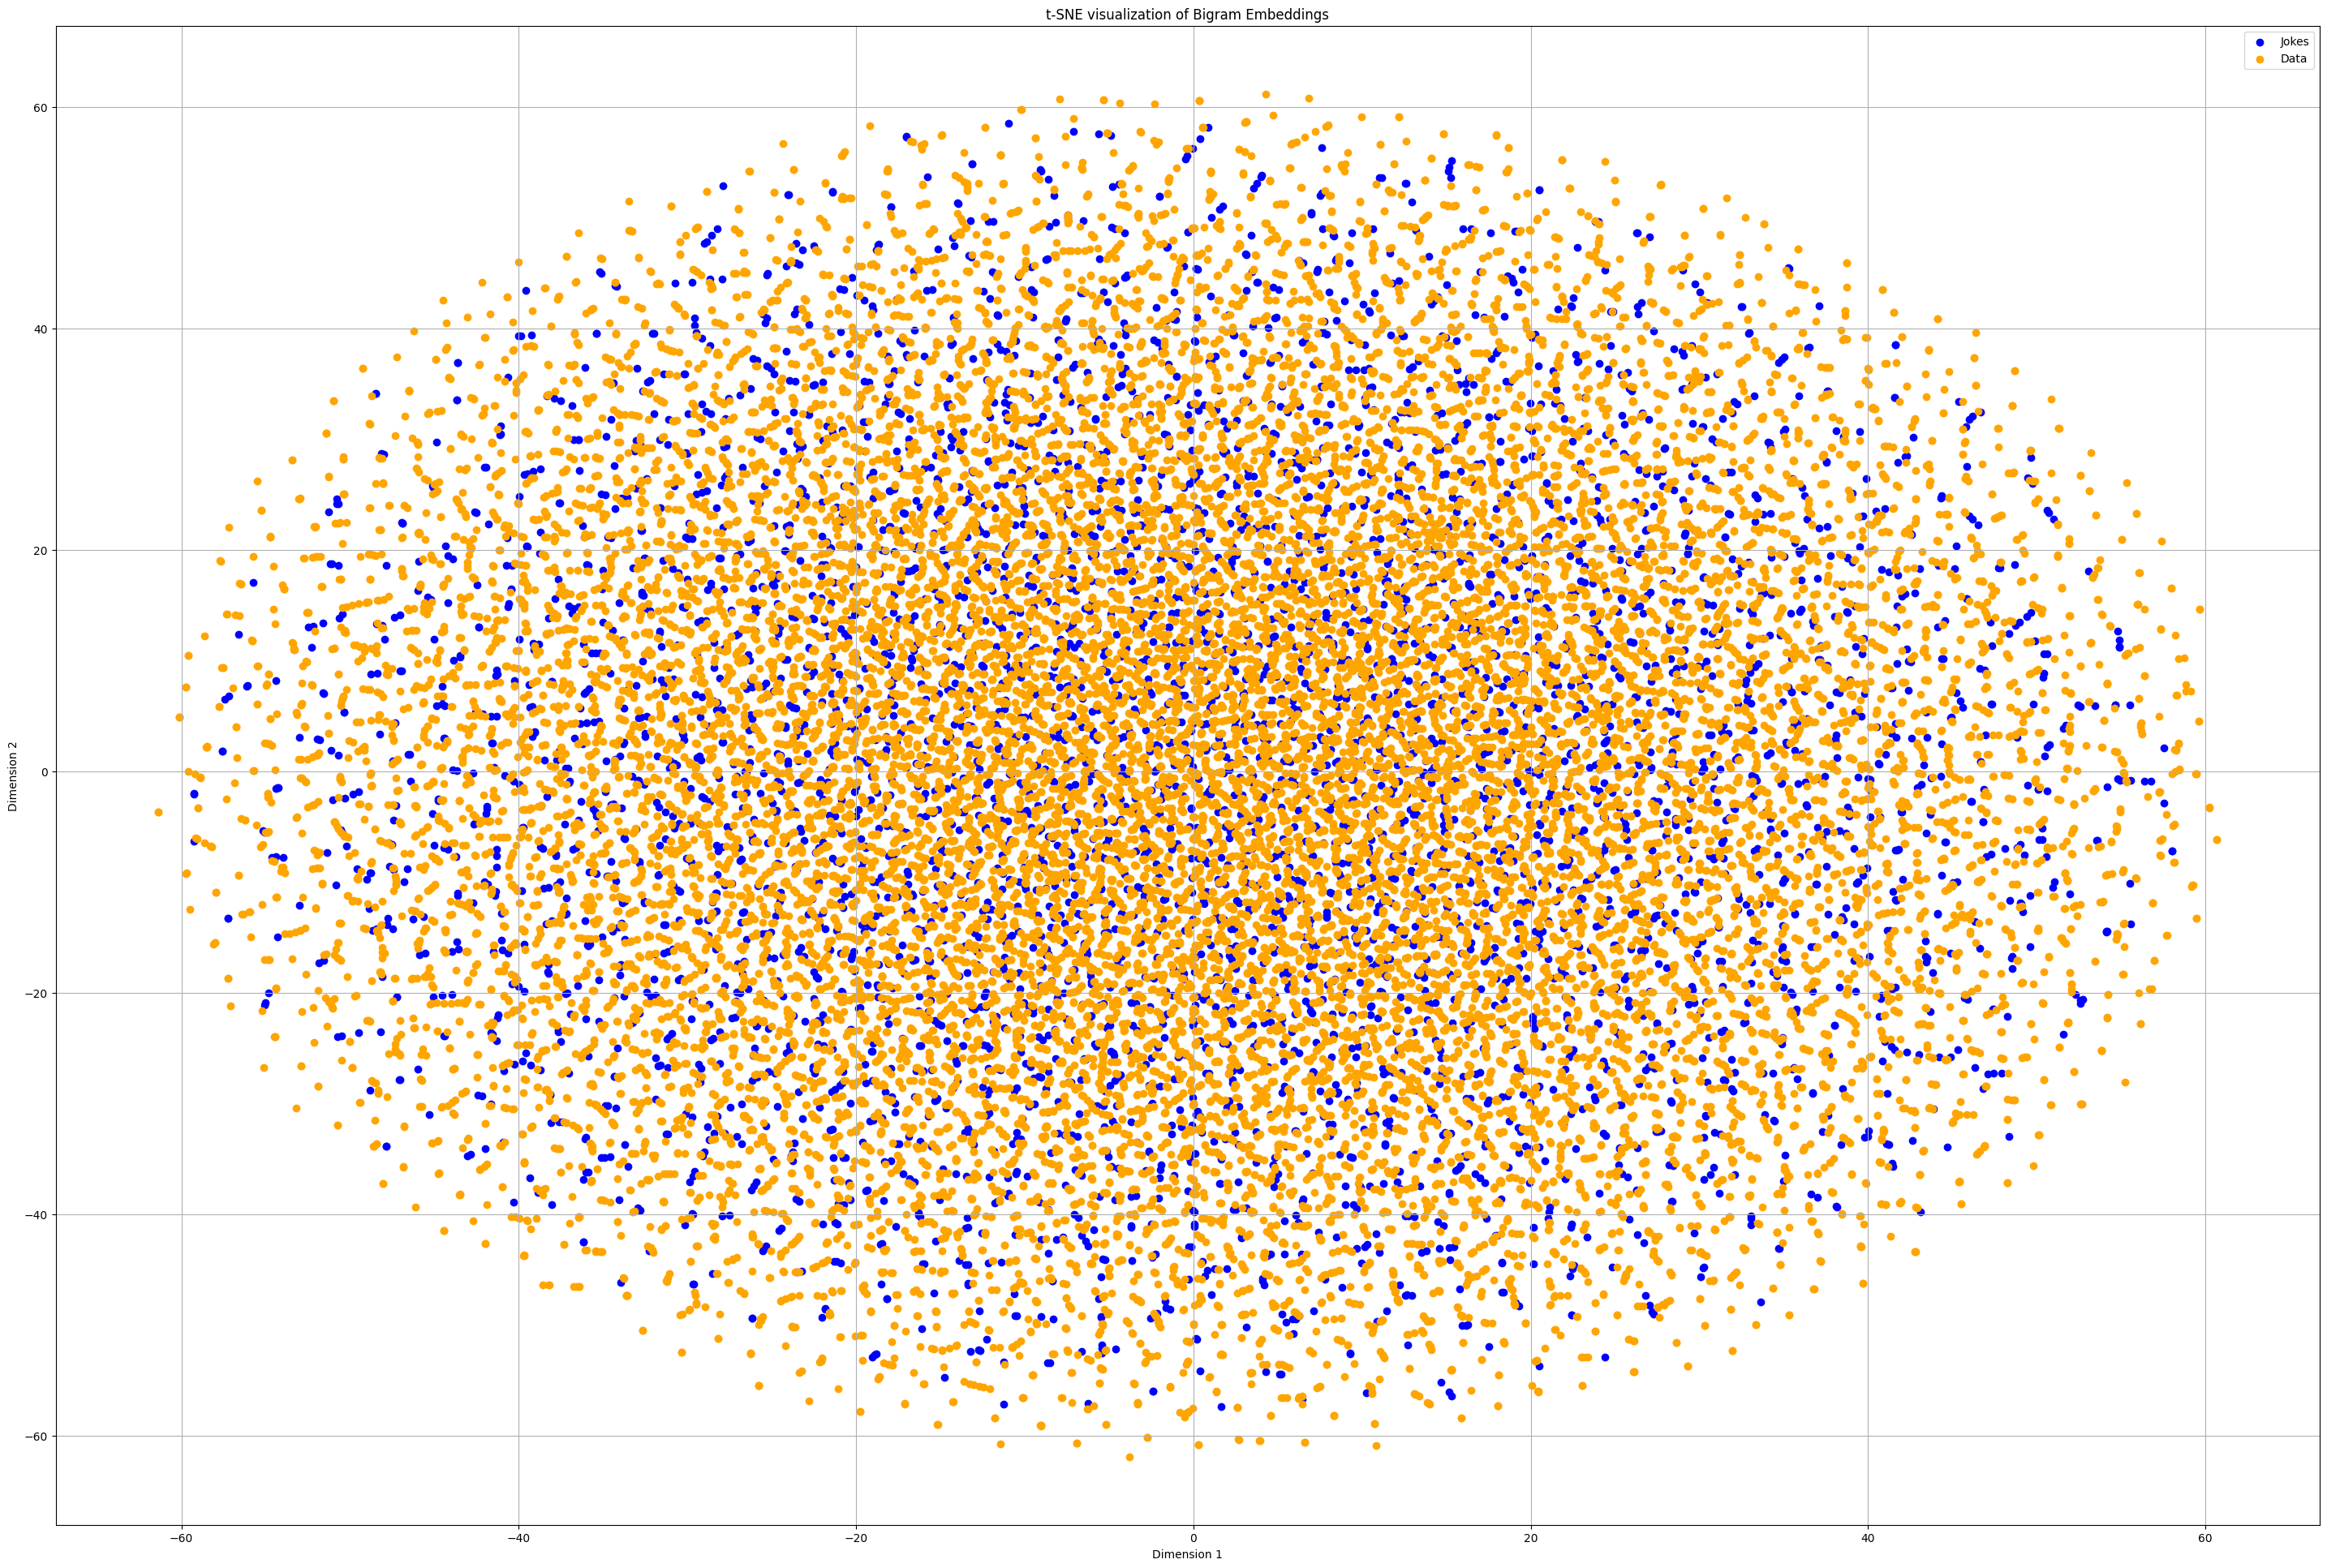

In [161]:
plt.figure(figsize=(36, 24))

plt.scatter(bigram_vectors_2d_a[:, 0], bigram_vectors_2d_a[:, 1], color='blue', label='Jokes')

plt.scatter(bigram_vectors_2d[:, 0], bigram_vectors_2d[:, 1], color='orange', label='Data')

plt.title('t-SNE visualization of Bigram Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.legend()
plt.show()